## Traditional Methods

In [2]:
import warnings
warnings.filterwarnings("ignore")
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.feature import canny
from skimage.color import rgb2gray, label2rgb
from skimage.filters import sobel
from skimage.segmentation import watershed 
import scipy.ndimage as nd

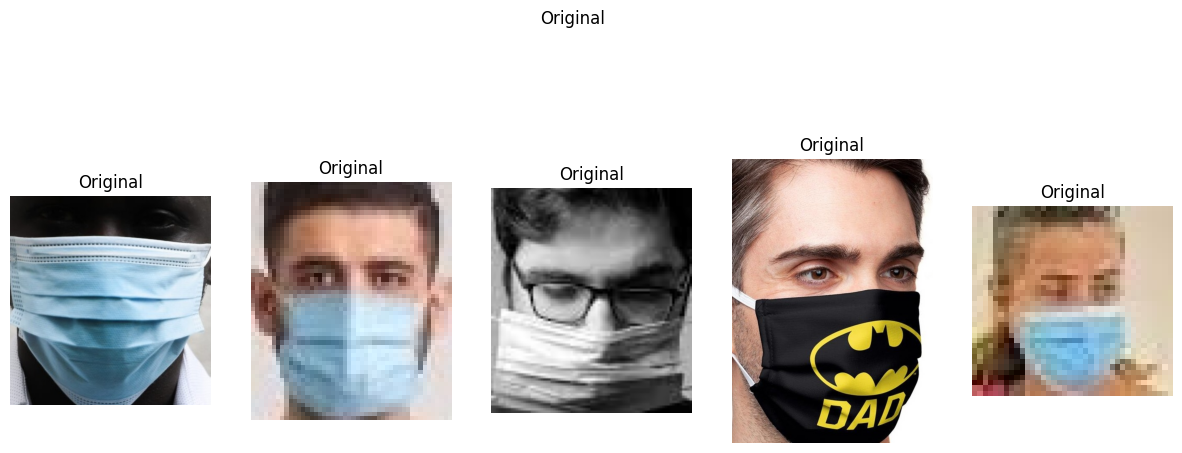

In [3]:

image_dir = "MSFD/1/face_crop/"
file_names = [f"{str(i).zfill(6)}_1.jpg" for i in range(5)]  # 000000_1.jpg to 000004_1.jpg

# Load images into an array
images = []
for file_name in file_names:
    image_path = os.path.join(image_dir, file_name)
    image = cv2.imread(image_path)
    if image is not None:
        images.append(image)
    else:
        print(f"Warning: Could not read {image_path}")



plt.figure(figsize=(15, 6))
for i, image in enumerate(images):
    image_2 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, i + 1)
    plt.imshow(image_2)
    plt.title("Original")
    plt.axis("off")
plt.suptitle("Original")
plt.show()



## Thresholding

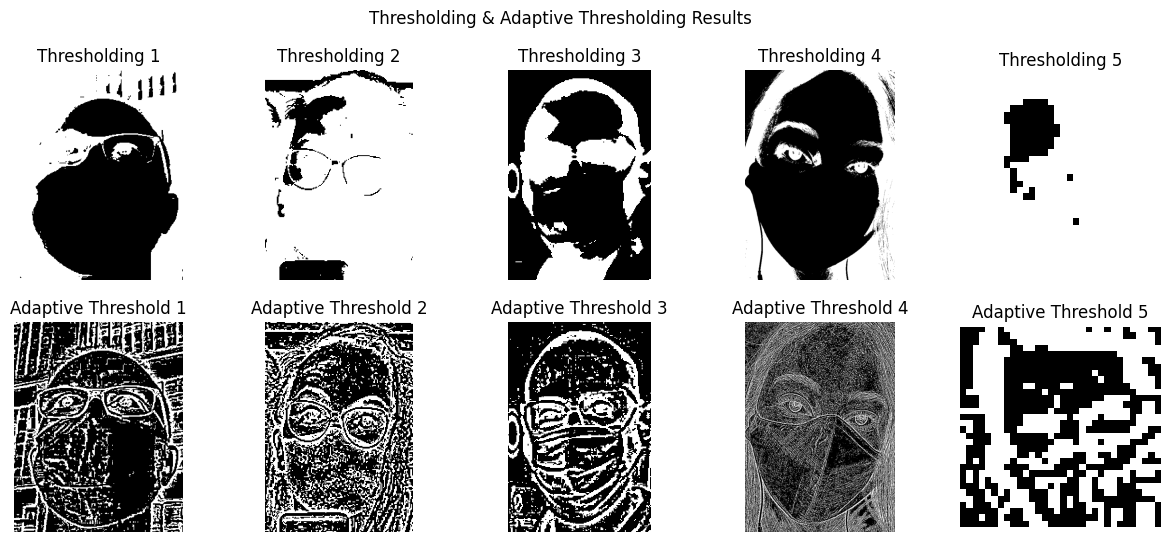

Average IoU: 0.1414
Average Dice: 0.0009


In [4]:
# Function to compute IoU
def compute_iou(mask_pred, mask_gt):
    intersection = np.logical_and(mask_pred, mask_gt).sum()
    union = np.logical_or(mask_pred, mask_gt).sum()
    return intersection / union if union > 0 else 0

# Function to compute Dice coefficient
def compute_dice(mask_pred, mask_gt):
    intersection = np.logical_and(mask_pred, mask_gt).sum()
    total_pixels = mask_pred.sum() + mask_gt.sum()
    return (2 * intersection) / total_pixels if total_pixels > 0 else 0

# Directories
image_dir = "MSFD/1/face_crop/"
mask_dir = "MSFD/1/face_crop_segmentation/"

# List image files
image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")][:5]  # First 5 images

iou_scores = []
dice_scores = []

# Thresholding and Evaluation
plt.figure(figsize=(15, 6))
for i, file_name in enumerate(image_files):
    image_path = os.path.join(image_dir, file_name)
    mask_path = os.path.join(mask_dir, file_name)

    if not os.path.exists(mask_path):
        continue

    # Load Image and Ground Truth Mask
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mask_gt = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    _, mask_gt = cv2.threshold(mask_gt, 127, 255, cv2.THRESH_BINARY)

    # Basic Thresholding
    _, mask_thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

    # Adaptive Thresholding
    mask_adaptive = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                          cv2.THRESH_BINARY_INV, 11, 2)

    # Compute IoU and Dice
    iou = compute_iou(mask_thresh, mask_gt)
    dice = compute_dice(mask_thresh, mask_gt)
    iou_scores.append(iou)
    dice_scores.append(dice)

    # Visualization
    plt.subplot(2, 5, i + 1)
    plt.imshow(mask_thresh, cmap="gray")
    plt.title(f"Thresholding {i+1}")
    plt.axis("off")

    plt.subplot(2, 5, i + 6)
    plt.imshow(mask_adaptive, cmap="gray")
    plt.title(f"Adaptive Threshold {i+1}")
    plt.axis("off")

plt.suptitle("Thresholding & Adaptive Thresholding Results")
plt.show()

# Print Average IoU and Dice Score
print(f"Average IoU: {np.mean(iou_scores):.4f}")
print(f"Average Dice: {np.mean(dice_scores):.4f}")


## Clustering

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x72ad389e5310>
Traceback (most recent call last):
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

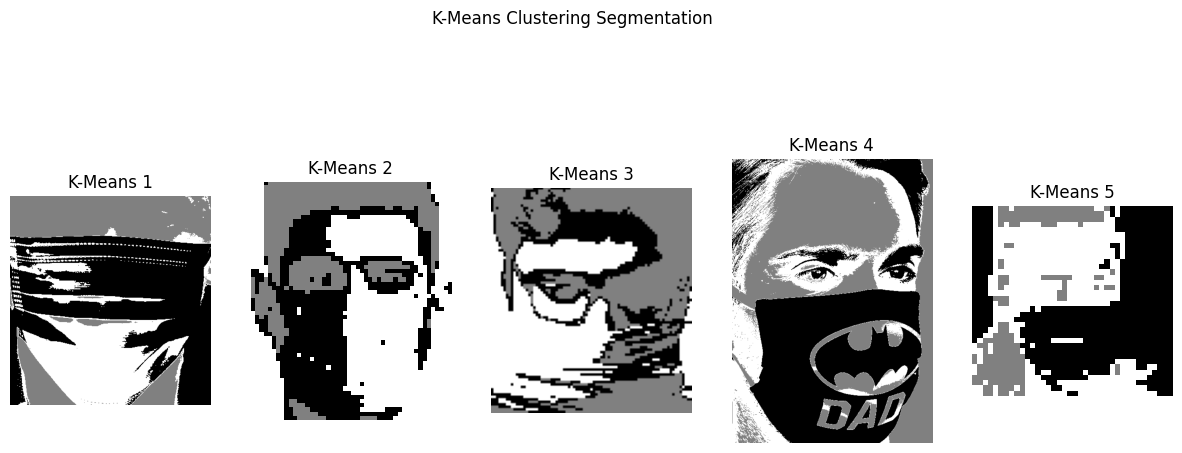

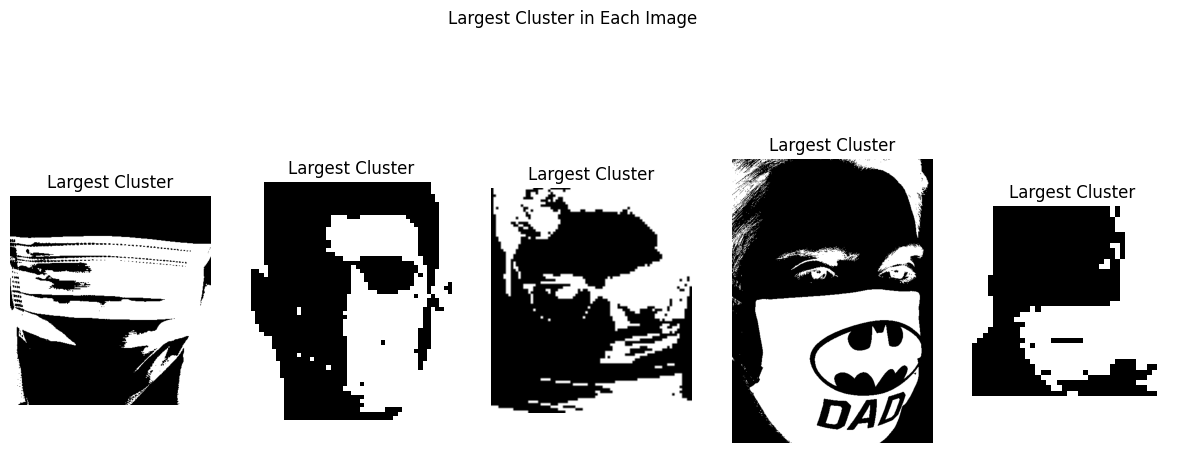

In [4]:

plt.figure(figsize=(15, 6))

largest_masks = []

for i, image in enumerate(images):
    # Convert image to LAB color space for better clustering
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    pixels = lab.reshape((-1, 3))

    # Apply K-Means clustering (5 clusters)
    kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)
    labels = kmeans.fit_predict(pixels)
    
    # Reshape labels to image shape
    mask_kmeans = labels.reshape(image.shape[:2])

    # Display K-Means result
    plt.subplot(1, 5, i + 1)
    plt.imshow(mask_kmeans, cmap="gray")
    plt.title(f"K-Means {i+1}")
    plt.axis("off")

    # Find the Largest Cluster
    unique, counts = np.unique(mask_kmeans, return_counts=True)
    largest_cluster = unique[np.argmax(counts)]  # Cluster with max area

    # Extract largest cluster
    largest_mask = np.uint8(mask_kmeans == largest_cluster) * 255
    largest_masks.append(largest_mask)  # Store for next plot

plt.suptitle("K-Means Clustering Segmentation")
plt.show()

plt.figure(figsize=(15, 6))
for i, largest_mask in enumerate(largest_masks):
    plt.subplot(1, 5, i + 1)
    plt.imshow(largest_mask, cmap="gray")
    plt.title(f"Largest Cluster")
    plt.axis("off")

plt.suptitle("Largest Cluster in Each Image")
plt.show()

# largest cluster appear to have parts of the mask in most images

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7b416637f1f0>
Traceback (most recent call last):
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

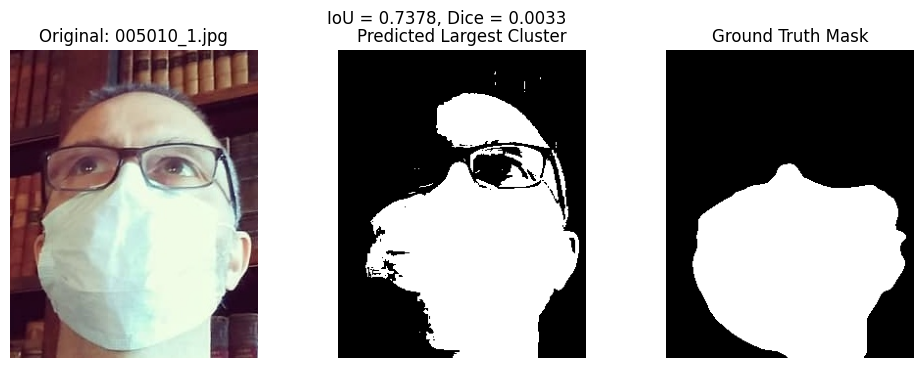

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7b4162373790>
Traceback (most recent call last):
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

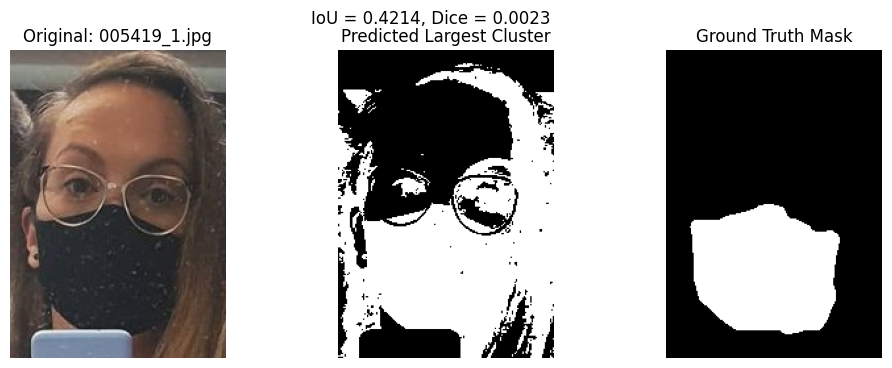

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7b41622af700>
Traceback (most recent call last):
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

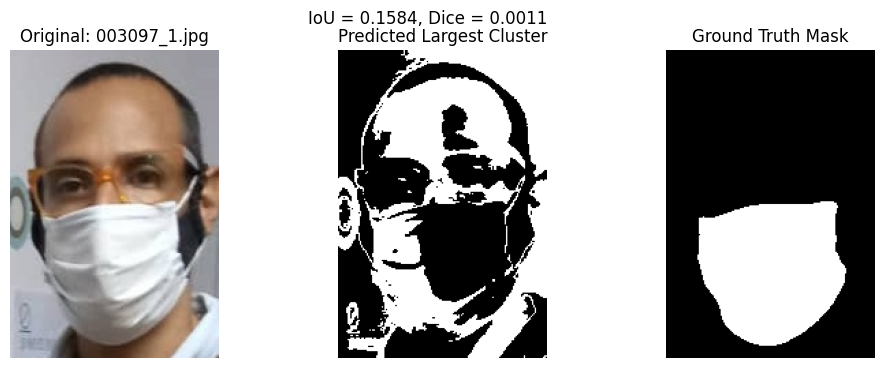

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7b4166b88430>
Traceback (most recent call last):
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

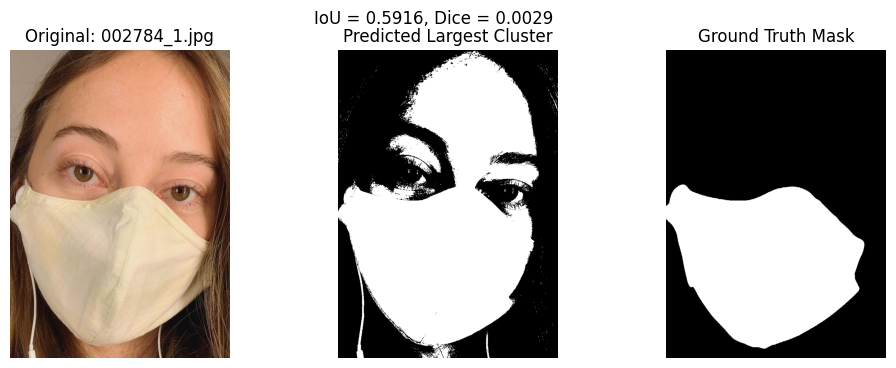

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7b4166360dc0>
Traceback (most recent call last):
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

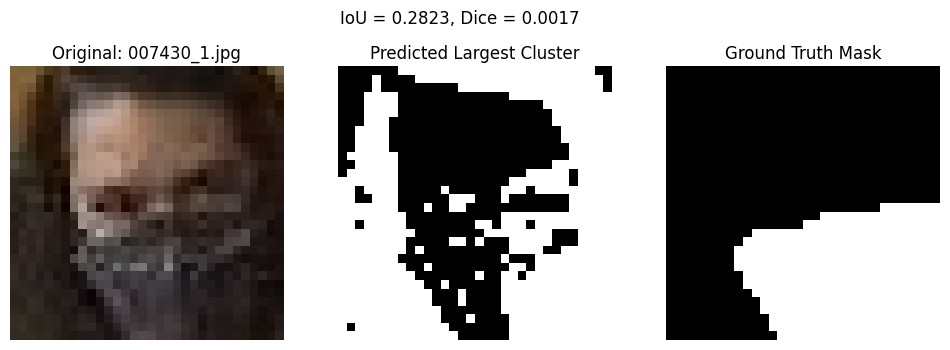

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7b41662c8790>
Traceback (most recent call last):
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

In [ ]:
def get_largest_cluster(image, n_clusters=3):
    # Convert to LAB for better color clustering
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    pixels = lab.reshape((-1, 3))

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
    labels = kmeans.fit_predict(pixels)

    # Reshape labels to match image
    mask_kmeans = labels.reshape(image.shape[:2])

    # Find the largest cluster
    unique, counts = np.unique(mask_kmeans, return_counts=True)
    largest_cluster = unique[np.argmax(counts)]

    # Create binary mask for the largest cluster
    largest_mask = np.uint8(mask_kmeans == largest_cluster) * 255
    
    return largest_mask

def compute_iou(mask_pred, mask_gt):
    intersection = np.logical_and(mask_pred, mask_gt).sum()
    union = np.logical_or(mask_pred, mask_gt).sum()
    
    if union == 0:
        return 0  # Avoid division by zero
    
    return intersection / union

def compute_dice(mask_pred, mask_gt):
    intersection = np.logical_and(mask_pred, mask_gt).sum()
    total_pixels = mask_pred.sum() + mask_gt.sum()
    
    if total_pixels == 0:
        return 0  # Avoid division by zero
    
    return (2 * intersection) / total_pixels

image_dir = "MSFD/1/face_crop/"
mask_dir = "MSFD/1/face_crop_segmentation/"

iou_scores = []
dice_scores = []
i = 0
for file_name in os.listdir(image_dir):
    if not file_name.endswith(".jpg"):
        continue
    
    image_path = os.path.join(image_dir, file_name)
    mask_path = os.path.join(mask_dir, file_name)
    
    if not os.path.exists(image_path) or not os.path.exists(mask_path):
        continue

    # Read original image & ground truth mask
    image = cv2.imread(image_path)
    mask_gt = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale

    # Ensure binary ground truth mask (thresholding)
    _, mask_gt = cv2.threshold(mask_gt, 127, 255, cv2.THRESH_BINARY)

    # Get the largest K-Means cluster
    mask_pred = get_largest_cluster(image, n_clusters=3)

    # Compute IoU and Dice score
    iou = compute_iou(mask_pred, mask_gt)
    dice = compute_dice(mask_pred, mask_gt)
    iou_scores.append(iou)
    dice_scores.append(dice)

    i += 1

    if i <= 5:
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Original: {file_name}")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(mask_pred, cmap="gray")
        plt.title("Predicted Largest Cluster")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(mask_gt, cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.suptitle(f"IoU = {iou:.4f}, Dice = {dice:.4f}")
        plt.show()


In [6]:
mean_iou = np.mean(iou_scores)
print(f"Mean IoU: {mean_iou:.4f}")

mean_dice = np.mean(dice_scores)
print(f"Mean dice: {mean_dice:.4f}")



Mean IoU: 0.3406
Mean dice: 0.0018


## Watershed segmentation

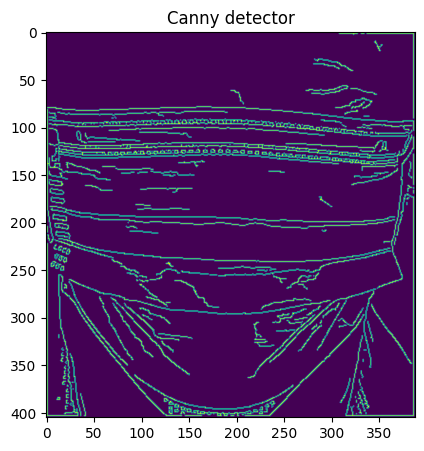

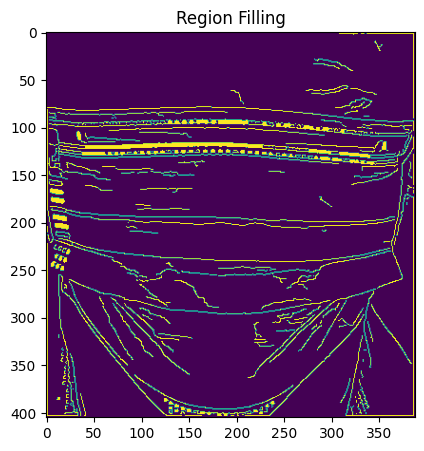

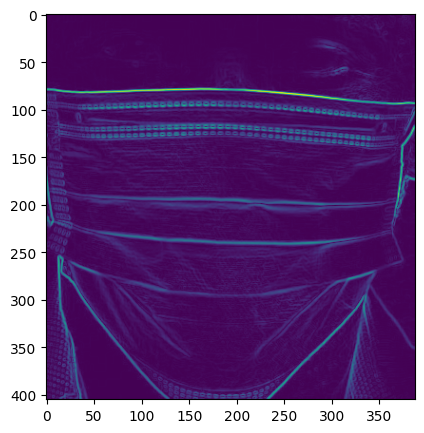

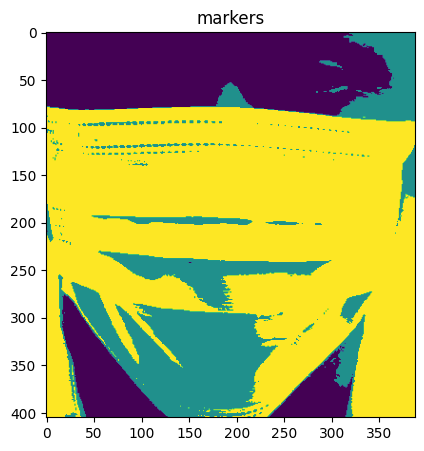

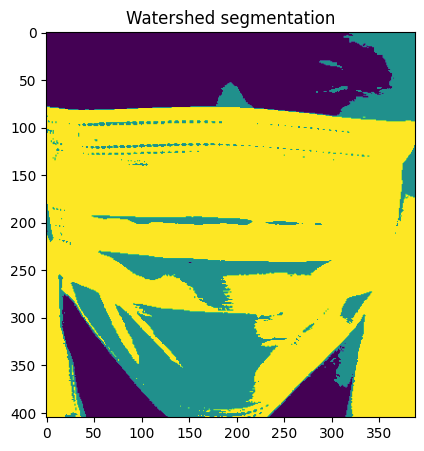

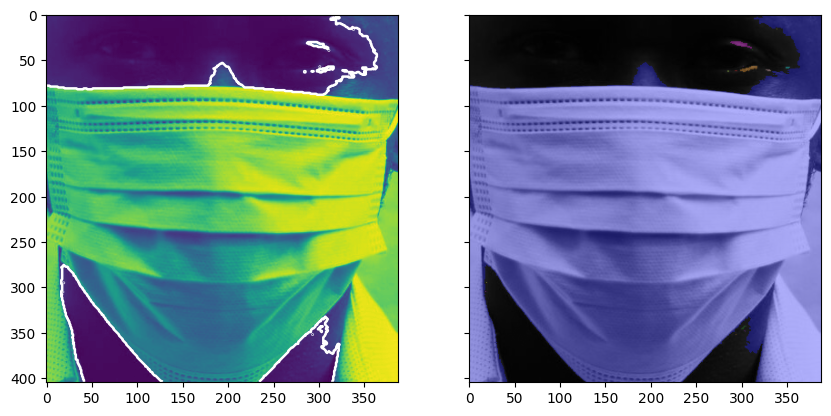

In [7]:
plt.rcParams["figure.figsize"] = (7,5)
%matplotlib inline

image_dir = "MSFD/1/face_crop/"
file_name = "000000_1.jpg"
image_path = os.path.join(image_dir, file_name)

# Load Image
face_mask = cv2.imread(image_path)

# load images and convert grayscale
face_mask_wh = rgb2gray(face_mask)

# apply edge segmentation
# plot canny edge detection
edges = canny(face_mask_wh)
plt.imshow(edges, interpolation='gaussian')
plt.title('Canny detector')
plt.show()
# fill regions to perform edge segmentation
fill_im = nd.binary_fill_holes(edges)
plt.imshow(fill_im)
plt.title('Region Filling')
plt.show()

# Region Segmentation
# First we print the elevation map
elevation_map = sobel(face_mask_wh)
plt.imshow(elevation_map)
plt.show()


markers = np.zeros_like(face_mask_wh)
markers[face_mask_wh < 0.156862745] = 1  # 70/255
markers[(face_mask_wh >= 0.156862745) & (face_mask_wh < 0.470588235)] = 2  # 70/255 to 150/255
markers[face_mask_wh >= 0.470588235] = 3  # 150/255 and above


plt.imshow(markers)
plt.title('markers')
plt.show()

# Perform watershed region segmentation 
segmentation = watershed(elevation_map, markers)  # Use watershed from skimage.segmentation

plt.imshow(segmentation)
plt.title('Watershed segmentation')
plt.show()

# plot overlays and contour
segmentation = nd.binary_fill_holes(segmentation - 1)
label_rock, _ = nd.label(segmentation)
# overlay image with different labels
image_label_overlay = label2rgb(label_rock, image=face_mask_wh)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10), sharey=True)
ax1.imshow(face_mask_wh)
ax1.contour(segmentation, [0.8], linewidths=1.8, colors='w')
ax2.imshow(image_label_overlay)
plt.show()

fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)


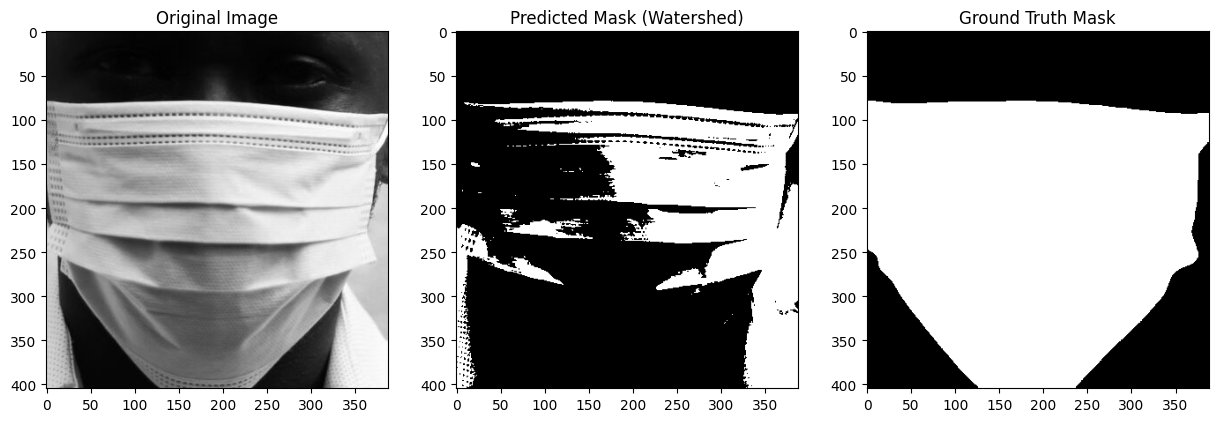

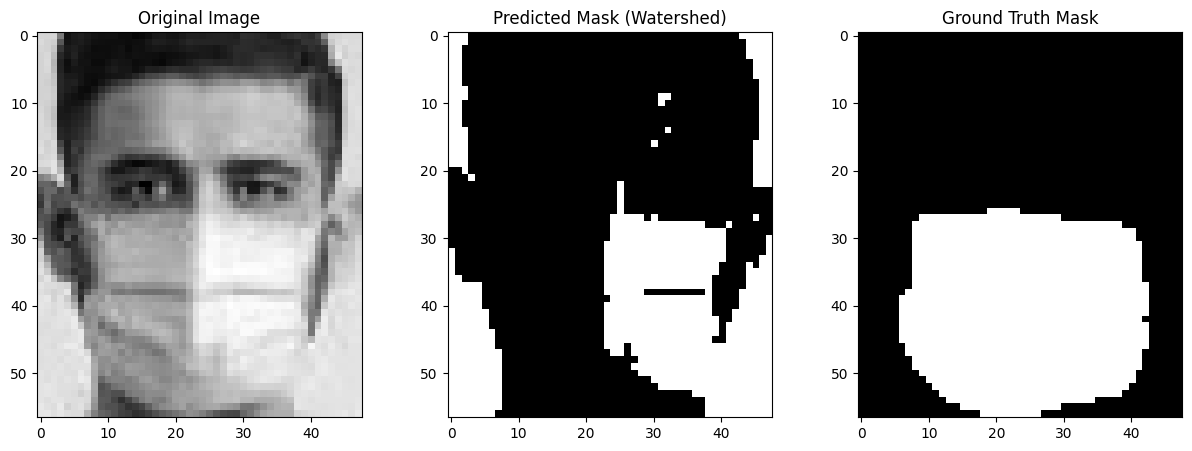

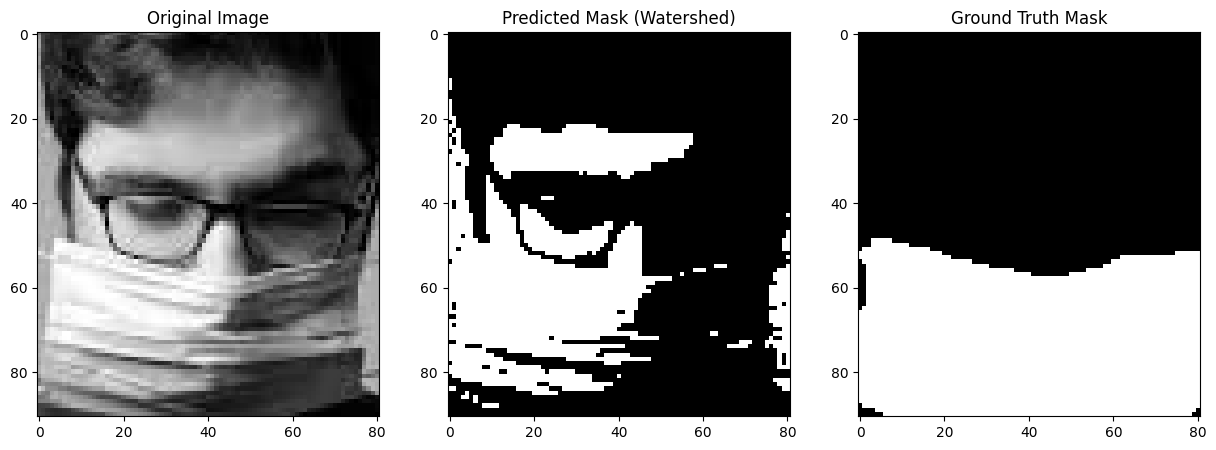

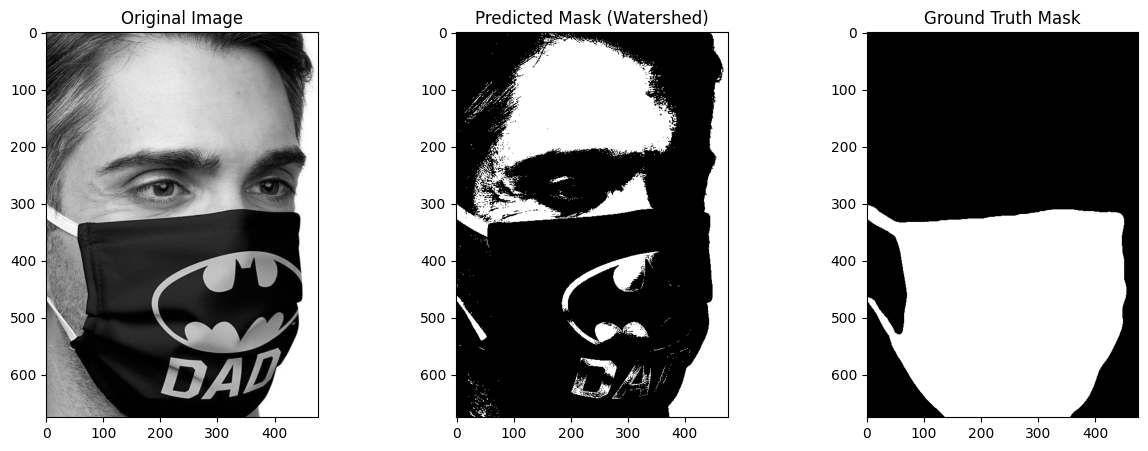

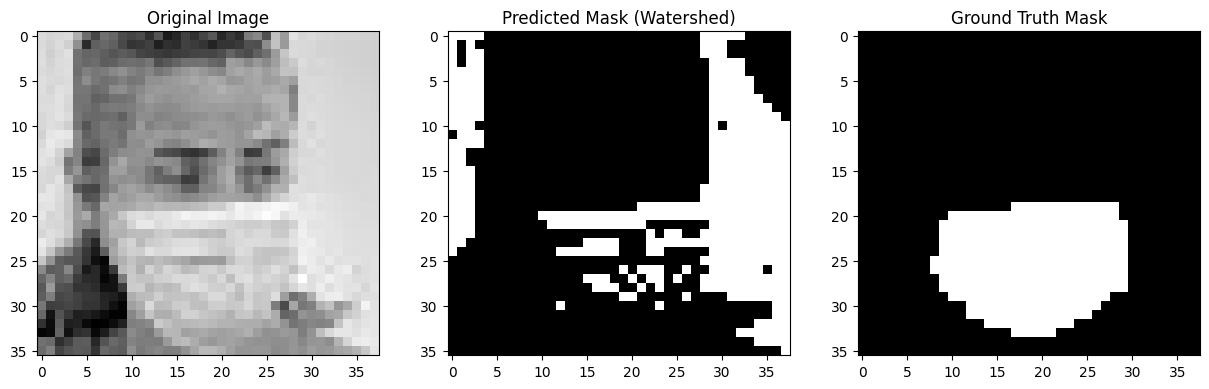

In [9]:
# Paths
image_dir = "MSFD/1/face_crop/"
mask_dir = "MSFD/1/face_crop_segmentation/"  # Ground truth masks

# Function to Compute IoU
def compute_iou(pred_mask, true_mask):
    intersection = np.logical_and(pred_mask, true_mask).sum()
    union = np.logical_or(pred_mask, true_mask).sum()
    return intersection / union if union > 0 else 0

# Function to Compute Dice Score
def compute_dice(pred_mask, true_mask):
    intersection = np.logical_and(pred_mask, true_mask).sum()
    total_pixels = pred_mask.sum() + true_mask.sum()
    return (2 * intersection) / total_pixels if total_pixels > 0 else 0

image_files = sorted(os.listdir(image_dir))

ious = []  # Store IoU values
dice_scores = []  # Store Dice scores

for file_name in image_files:
    try:
        image_path = os.path.join(image_dir, file_name)
        mask_path = os.path.join(mask_dir, file_name)

        # Load Image & Ground Truth Mask
        face_mask = cv2.imread(image_path)
        face_mask_gray = rgb2gray(face_mask)
        true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) > 128  # Convert to binary mask

        # Edge Detection
        edges = canny(face_mask_gray, sigma=1.5)
        filled_regions = nd.binary_fill_holes(edges)

        # Elevation Map
        face_mask_blurred = nd.gaussian_filter(face_mask_gray, sigma=2)
        elevation_map = sobel(face_mask_blurred)

        # Adaptive Thresholds
        low_thresh = np.percentile(face_mask_gray, 30)
        high_thresh = np.percentile(face_mask_gray, 70)

        # Create Markers
        markers = np.zeros_like(face_mask_gray)
        markers[face_mask_gray < low_thresh] = 1
        markers[(face_mask_gray >= low_thresh) & (face_mask_gray < high_thresh)] = 2
        markers[face_mask_gray >= high_thresh] = 3  # Foreground (mask)

        # Watershed Segmentation
        segmentation = watershed(elevation_map, markers)

        # Extract Whitest Region (Mask)
        pred_mask = segmentation == segmentation.max()  # Select highest intensity region

        # Compute IoU and Dice Score
        iou = compute_iou(pred_mask, true_mask)
        dice = compute_dice(pred_mask, true_mask)
        ious.append(iou)
        dice_scores.append(dice)
        if len(ious) == 200:
            break
        if len(ious) <= 5:
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            axs[0].imshow(face_mask_gray, cmap="gray")
            axs[0].set_title("Original Image")
            axs[1].imshow(pred_mask, cmap="gray")
            axs[1].set_title("Predicted Mask (Watershed)")
            axs[2].imshow(true_mask, cmap="gray")
            axs[2].set_title("Ground Truth Mask")
            plt.show()
    except Exception:
        continue

In [10]:
print(f"Average IoU over all images: {np.mean(ious):.4f}")
print(f"Average Dice Score over all images: {np.mean(dice_scores):.4f}")


Average IoU over all images: 0.3333
Average Dice Score over all images: 0.4452


## U-Net

In [1]:
!pip install gdown

In [2]:
import gdown
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from google.colab.patches import cv2_imshow
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

In [3]:
gdown.download("https://drive.google.com/uc?id=1KycQj4dik91RuBGvbhDJou7YDQEKAH2Z", output="dataset.zip", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1KycQj4dik91RuBGvbhDJou7YDQEKAH2Z
From (redirected): https://drive.google.com/uc?id=1KycQj4dik91RuBGvbhDJou7YDQEKAH2Z&confirm=t&uuid=690e3e7e-17b9-446b-a308-3af1284bb921
To: /content/dataset.zip
100%|██████████| 2.25G/2.25G [00:37<00:00, 60.5MB/s]


'dataset.zip'

In [4]:
!unzip dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: MSFD/1/img/006604.jpg   
  inflating: MSFD/1/img/006605.jpg   
  inflating: MSFD/1/img/006606.jpg   
  inflating: MSFD/1/img/006607.jpg   
  inflating: MSFD/1/img/006608.jpg   
  inflating: MSFD/1/img/006609.jpg   
  inflating: MSFD/1/img/006610.jpg   
  inflating: MSFD/1/img/006611.jpg   
  inflating: MSFD/1/img/006612.jpg   
  inflating: MSFD/1/img/006613.jpg   
  inflating: MSFD/1/img/006614.jpg   
  inflating: MSFD/1/img/006615.jpg   
  inflating: MSFD/1/img/006616.jpg   
  inflating: MSFD/1/img/006617.jpg   
  inflating: MSFD/1/img/006618.jpg   
  inflating: MSFD/1/img/006619.jpg   
  inflating: MSFD/1/img/006620.jpg   
  inflating: MSFD/1/img/006621.jpg   
  inflating: MSFD/1/img/006622.jpg   
  inflating: MSFD/1/img/006623.jpg   
  inflating: MSFD/1/img/006624.jpg   
  inflating: MSFD/1/img/006625.jpg   
  inflating: MSFD/1/img/006626.jpg   
  inflating: MSFD/1/img/006627.jpg   
  inflating: MSFD/1/img/006628.jpg   

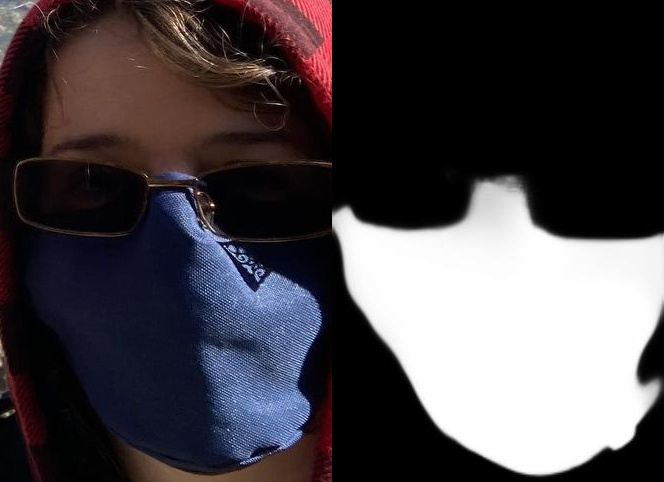

In [5]:
# Display a sample image and its segmented output
sample = cv2.imread("MSFD/1/face_crop/004768_1.jpg")
sample_segmented = cv2.imread("MSFD/1/face_crop_segmentation/004768_1.jpg")

cv2_imshow(np.hstack((sample, sample_segmented)))

In [6]:
# Get number of images in the dataset
!ls -l MSFD/1/face_crop/ | wc -l

9384


In [7]:
# U-Net Architecture
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.up4 = DoubleConv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.up3 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.up2 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.up1 = DoubleConv(128, 64)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.pool1(d1))
        d3 = self.down3(self.pool2(d2))
        d4 = self.down4(self.pool3(d3))
        bn = self.bottleneck(self.pool4(d4))
        u4 = self.up4(torch.cat([self.upconv4(bn), d4], dim=1))
        u3 = self.up3(torch.cat([self.upconv3(u4), d3], dim=1))
        u2 = self.up2(torch.cat([self.upconv2(u3), d2], dim=1))
        u1 = self.up1(torch.cat([self.upconv1(u2), d1], dim=1))
        return self.final_conv(u1)


In [8]:
image_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

mask_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Dataset Class
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, image_transform, mask_transform):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = self.image_transform(Image.open(self.image_paths[idx]).convert("RGB"))
        mask = self.mask_transform(Image.open(self.mask_paths[idx]).convert("L"))
        return image, mask


In [9]:
image_names = os.listdir("MSFD/1/face_crop")
images = ["MSFD/1/face_crop/" + name for name in image_names]
masks = ["MSFD/1/face_crop_segmentation/" + name for name in image_names]

dataset = SegmentationDataset(images, masks, image_transform, mask_transform)
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.7, 0.15, 0.15], generator=torch.Generator().manual_seed(42))

In [10]:
print("Size of train dataset:", len(train_dataset))
print("Size of val dataset:", len(val_dataset))
print("Size of test dataset:", len(test_dataset))

Size of train dataset: 6569
Size of val dataset: 1407
Size of test dataset: 1407


In [11]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = UNet(in_channels=3, out_channels=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [13]:
def dice_score(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum()
    dice = (2 * intersection + 1e-7) / (union + 1e-7)
    return dice.item()

In [14]:
epochs = 4

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_dice = 0
    with torch.no_grad():
        for val_images, val_masks in val_loader:
            val_images, val_masks = val_images.to(device), val_masks.to(device)
            val_outputs = model(val_images)
            val_dice += dice_score(torch.sigmoid(val_outputs), val_masks)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss/len(train_loader):.4f}, Val Dice = {val_dice/len(val_loader):.4f}")

Epoch 1: Train Loss = 0.2068, Val Dice = 0.9046
Epoch 2: Train Loss = 0.1255, Val Dice = 0.9383
Epoch 3: Train Loss = 0.0998, Val Dice = 0.9374
Epoch 4: Train Loss = 0.0914, Val Dice = 0.9445


In [15]:
os.rename("MSFD/1/face_crop_segmentation/c.jpg", "MSFD/1/face_crop_segmentation/000601_1.jpg")

In [16]:
model.eval()
total_dice = 0
num_samples = 0

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        preds = torch.sigmoid(outputs) > 0.5

        # Dice (per batch average)
        batch_dice = dice_score(outputs, masks)
        total_dice += batch_dice
        num_samples += 1

avg_dice = total_dice / num_samples
print(f"Average Dice Score on Test Set: {avg_dice:.4f}")

Average Dice Score on Test Set: 0.9433


In [18]:
img_path = "MSFD/1/face_crop/000601_1.jpg"

sample_img = Image.open(img_path).convert('RGB')
model.eval()

with torch.no_grad():
    img_tensor = image_transform(sample_img).unsqueeze(0).to(device)
    output = model(img_tensor)
    pred_mask = torch.sigmoid(output)
    pred_mask = (pred_mask > 0.5).float()
    pred_mask = pred_mask.squeeze().cpu().numpy()

pred_mask = np.uint8(pred_mask * 255)

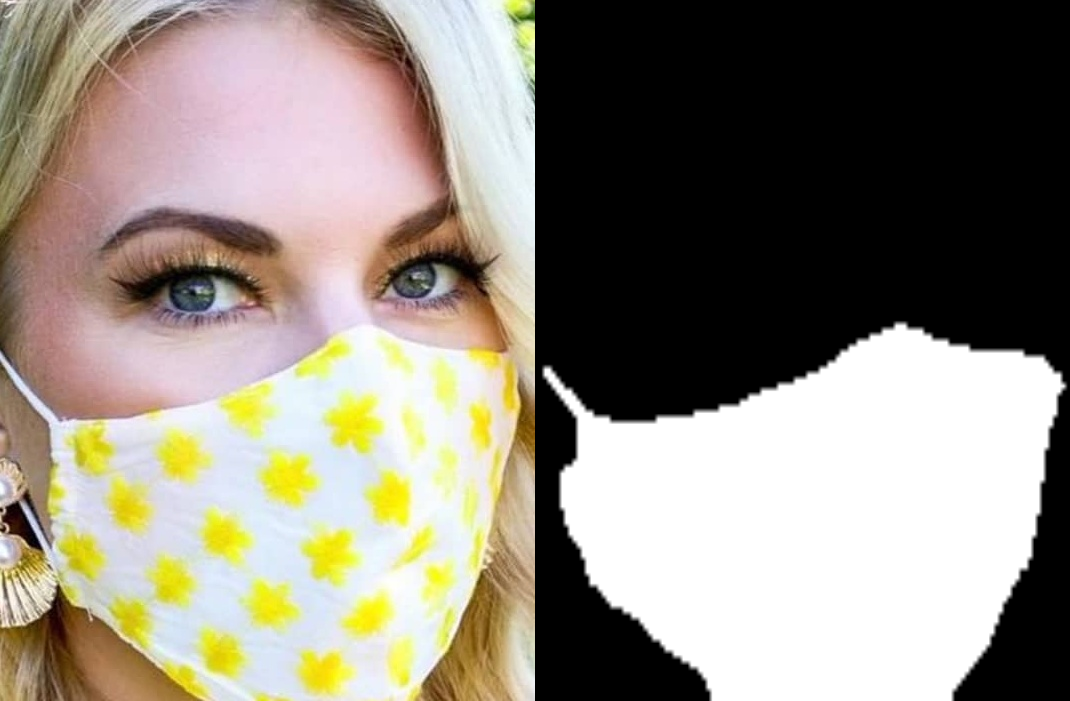

In [19]:
# Inference
img_path = "MSFD/1/face_crop/000601_1.jpg"

sample_img = Image.open(img_path).convert('RGB')
model.eval()

with torch.no_grad():
    img_tensor = image_transform(sample_img).unsqueeze(0).to(device)
    output = model(img_tensor)
    pred_mask = torch.sigmoid(output)
    pred_mask = (pred_mask > 0.5).float()
    pred_mask = pred_mask.squeeze().cpu().numpy()

pred_mask = np.uint8(pred_mask * 255)
pred_mask = cv2.resize(pred_mask, sample_img.size)
pred_mask_rgb = cv2.cvtColor(pred_mask, cv2.COLOR_GRAY2BGR)
sample_img = cv2.imread(img_path)
cv2_imshow(np.hstack((np.array(sample_img), pred_mask_rgb)))

In [20]:
torch.save(model.state_dict(), "unet_face_mask_segmentation.pth")